In [2]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.0 MB/s eta 0:00:00


Import library

In [3]:
import keras
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tensorflow.keras import layers, models
from collections import Counter
from sklearn.utils import shuffle
from tensorflow import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, BatchNormalization
from keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from keras.optimizers import Adam
from keras_tuner import RandomSearch
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [4]:
!pip install opencv-python

In [5]:
!pip install tensorflow

In [6]:
#import kagglehub

#data_path = kagglehub.dataset_download("atrithakar/banana-classification")
data_path = "."

Unzip the banana file


In [7]:
!unzip banana.zip

Streaming output truncated to the last 5000 lines.
  inflating: banana/banana_classification/train/rotten/musa-acuminata-rotten-a7940341-1d0a-11ec-98d8-d8c4975e38aa_jpg.rf.79e524ce0592a4e81c292156b4f6f037.jpg  
  inflating: banana/banana_classification/train/rotten/musa-acuminata-rotten-a796656f-1d0a-11ec-87e7-d8c4975e38aa_jpg.rf.3dc371287ecb8a9504c46fc562754b05.jpg  
  inflating: banana/banana_classification/train/rotten/musa-acuminata-rotten-a796656f-1d0a-11ec-87e7-d8c4975e38aa_jpg.rf.43b345592ce7d4173a13ddbe98417ed4.jpg  
  inflating: banana/banana_classification/train/rotten/musa-acuminata-rotten-a796656f-1d0a-11ec-87e7-d8c4975e38aa_jpg.rf.c288370327248753330882738506ddb0.jpg  
  inflating: banana/banana_classification/train/rotten/musa-acuminata-rotten-a798c793-1d0a-11ec-aee6-d8c4975e38aa_jpg.rf.0a03b4370e10bdf3e312217e3cd3b618.jpg  
  inflating: banana/banana_classification/train/rotten/musa-acuminata-rotten-a798c793-1d0a-11ec-aee6-d8c4975e38aa_jpg.rf.5ece1098e146c984a99e4e8de936

In [8]:
!ls

banana	banana.zip  sample_data


In [9]:
!ls "banana"

banana_classification


In [10]:
data_path = "banana"

Scanning through the banana files to see each train,test,val set

In [11]:
def load_images_from_folder(base_path, image_size=(32, 32)):
    categories = ['ripe', 'overripe', 'rotten', 'unripe']
    images = []
    labels = []

    for label, category in enumerate(categories):
        folder_path = os.path.join(base_path, category)
        for filename in os.listdir(folder_path):
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, image_size)
                    images.append(img)
                    labels.append(label)

    return np.array(images), np.array(labels)


X_train, y_train = load_images_from_folder(data_path + '/banana_classification/train')
X_test, y_test = load_images_from_folder(data_path + '/banana_classification/test')
X_val, y_val = load_images_from_folder(data_path + '/banana_classification/test')

print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)
print("Val set:", X_val.shape, y_val.shape)

Train set: (12676, 32, 32, 3) (12676,)
Test set: (563, 32, 32, 3) (563,)
Val set: (563, 32, 32, 3) (563,)


Scanning the train set each categories images amount

In [12]:
categories = ['ripe', 'overripe', 'rotten', 'unripe']
train_base_path = os.path.join(data_path, 'banana_classification', 'train')

print("Number of images in train dataset:")
for category in categories:
    folder_path = os.path.join(train_base_path, category)
    if os.path.exists(folder_path):
        num_images = len([filename for filename in os.listdir(folder_path) if filename.endswith(('.jpg', '.jpeg', '.png'))])
        print(f"- {category}: {num_images}")
    else:
        print(f"- {category}: Folder not found at {folder_path}")

Number of images in train dataset:
- ripe: 3522
- overripe: 2578
- rotten: 4020
- unripe: 2556


Randomly under sampling class balancing

In [13]:
pip install imbalanced-learn

In [14]:
def undersample(X, y):
    X = np.array(X)
    y = np.array(y)

    class_counts = Counter(y)
    min_count = min(class_counts.values())

    print(f"Undersampling all classes to {min_count} instances.")

    X_balanced = []
    y_balanced = []

    for label in class_counts:
        idx = np.where(y == label)[0]
        sampled_idx = np.random.choice(idx, min_count, replace=False)

        X_balanced.append(X[sampled_idx])
        y_balanced.append(y[sampled_idx])

    X_out = np.concatenate(X_balanced)
    y_out = np.concatenate(y_balanced)

    return shuffle(X_out, y_out, random_state=42)

In [15]:
X_train, y_train = undersample(X_train, y_train)

Undersampling all classes to 2556 instances.


In [16]:
class_counts_undersampled = Counter(y_train)

print("Number of images per class after undersampling:")
for label, count in class_counts_undersampled.items():

    categories = ['ripe', 'overripe', 'rotten', 'unripe']
    print(f"Class {label} ({categories[label]}): {count} images")

Number of images per class after undersampling:
Class 2 (rotten): 2556 images
Class 3 (unripe): 2556 images
Class 1 (overripe): 2556 images
Class 0 (ripe): 2556 images


Normalized data


In [17]:
X_train = X_train.astype("float64")
X_test = X_test.astype("float64")
X_val = X_val.astype("float64")
X_train /= 255
X_test /= 255
X_val /= 255
y_train  = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

Print out the each set shape

In [18]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((10224, 32, 32, 3),
 (563, 32, 32, 3),
 (563, 32, 32, 3),
 (10224, 4),
 (563, 4),
 (563, 4))

to show some of the train set data

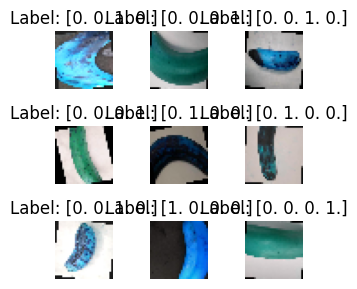

In [19]:
def plot_mnist_images(images, labels, num_images=9):
    grid_size = int(np.sqrt(num_images))

    plt.figure(figsize=(3, 3))

    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_mnist_images(X_train, y_train, num_images=9)

Showing y train

In [20]:
y_train

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]])

Running CNN model

In [21]:
!pip install keras_tuner

First CNN model (Conv2D (32&64), epochs=20, batch size = 80)

In [22]:
#CNN model first trial, Conv2D (32&64), epochs=20, batch size = 80
model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu', input_shape=(32,32,3),padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),activation='relu',padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3),activation='relu',input_shape=(32,32,3),padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='relu',padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax', kernel_regularizer=l2(0.001)))

model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=20,
                        batch_size=80,
                        validation_data=(X_val,y_val),
                        callbacks=[early_stopping, reduce_lr])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.6313 - loss: 1.6349 - val_accuracy: 0.2220 - val_loss: 3.9682 - learning_rate: 0.0010
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8559 - loss: 0.7890 - val_accuracy: 0.2913 - val_loss: 3.7317 - learning_rate: 0.0010
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8752 - loss: 0.6862 - val_accuracy: 0.3961 - val_loss: 4.7383 - learning_rate: 0.0010
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8942 - loss: 0.6194 - val_accuracy: 0.6128 - val_loss: 2.0246 - learning_rate: 0.0010
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8952 - loss: 0.5934 - val_accuracy: 0.7780 - val_loss: 1.2973 - learning_rate: 0.0010
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9124 - loss: 0.5245 - val_accuracy: 0.6892 - val_loss: 1.2455 - learning_rate: 0.0010
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9131 - loss: 0.5204 

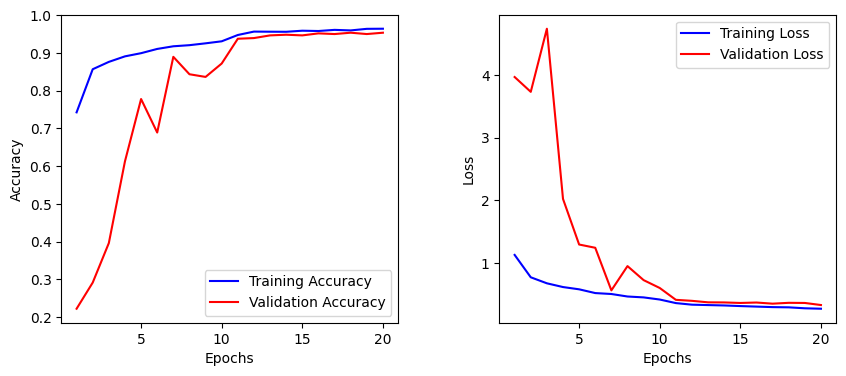

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
plt.subplots_adjust(wspace=0.3)
axes[0].plot(epochs, acc, 'b', label='Training Accuracy')
axes[0].plot(epochs, val_acc, 'r', label='Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'b', label='Training Loss')
axes[1].plot(epochs, val_loss, 'r', label='Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,773,038 (6.76 MB)

 Trainable params: 590,884 (2.25 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 1,181,770 (4.51 MB)

In [34]:
y_test

pred = model.predict(X_test)
y_pred = (pred>0.5)

print("              First CNN model classification report")
print(classification_report(y_test, y_pred))


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              First CNN model classification report
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       154
           1       0.90      0.96      0.93       113
           2       0.98      0.92      0.95       185
           3       0.97      0.99      0.98       111

   micro avg       0.95      0.95      0.95       563
   macro avg       0.95      0.96      0.95       563
weighted avg       0.95      0.95      0.95       563
 samples avg       0.95      0.95      0.95       563



18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


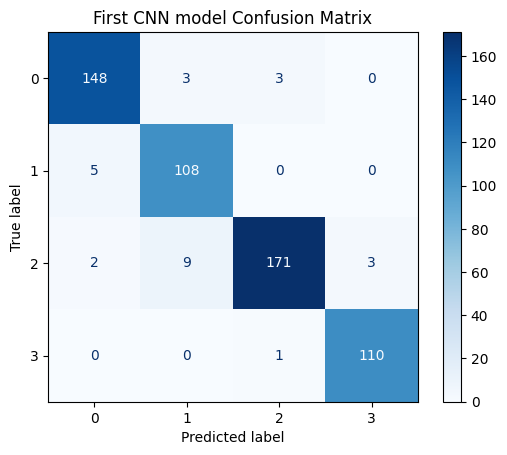

In [35]:
y_pred_probs = model.predict(X_test)
y_pred_probs = (y_pred_probs>0.5)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("First CNN model Confusion Matrix")
plt.show()

Second CNN model (Conv2D (32&64), epoch=25, batch size=100) the highest val accuracy

In [40]:
model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu', input_shape=(32,32,3),padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),activation='relu',padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3),activation='relu',input_shape=(32,32,3),padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='relu',padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=25,
                        batch_size=100,
                        validation_data=(X_val,y_val),
                        callbacks=[early_stopping, reduce_lr])

Epoch 1/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.5027 - loss: 2.1355 - val_accuracy: 0.2504 - val_loss: 5.4511 - learning_rate: 0.0010
Epoch 2/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8279 - loss: 0.8536 - val_accuracy: 0.2167 - val_loss: 5.2260 - learning_rate: 0.0010
Epoch 3/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8728 - loss: 0.7121 - val_accuracy: 0.4529 - val_loss: 2.9180 - learning_rate: 0.0010
Epoch 4/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8848 - loss: 0.6593 - val_accuracy: 0.4476 - val_loss: 3.5296 - learning_rate: 0.0010
Epoch 5/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9070 - loss: 0.5763 - val_accuracy: 0.4512 - val_loss: 3.1562 - learning_rate: 0.0010
Epoch 6/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9110 - loss: 0.5497 - val_accuracy: 0.8526 - val_loss: 0.6427 - learning_rate: 0.0010
Epoch 7/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9170 - loss: 0.5

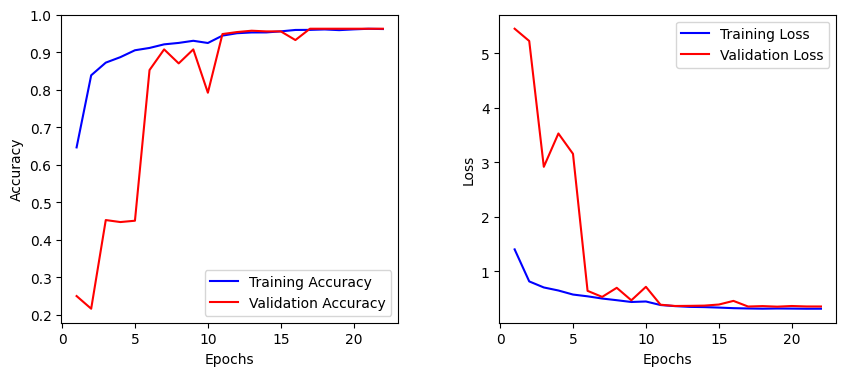

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

#Subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
plt.subplots_adjust(wspace=0.3)
axes[0].plot(epochs, acc, 'b', label='Training Accuracy')
axes[0].plot(epochs, val_acc, 'r', label='Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'b', label='Training Loss')
axes[1].plot(epochs, val_loss, 'r', label='Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

In [42]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,773,038 (6.76 MB)

 Trainable params: 590,884 (2.25 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 1,181,770 (4.51 MB)

In [43]:
y_test

pred = model.predict(X_test)
y_pred = (pred>0.5)

print("              Second CNN model classification report")
print(classification_report(y_test, y_pred))


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
              Second CNN model classification report
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       154
           1       0.92      0.96      0.94       113
           2       0.97      0.95      0.96       185
           3       0.98      0.98      0.98       111

   micro avg       0.96      0.96      0.96       563
   macro avg       0.96      0.96      0.96       563
weighted avg       0.96      0.96      0.96       563
 samples avg       0.96      0.96      0.96       563



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


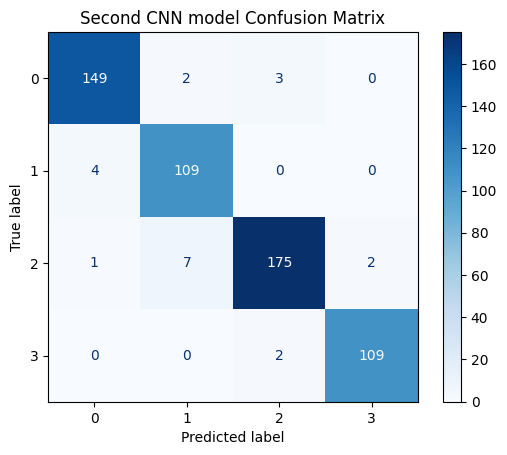

In [44]:
y_pred_probs = model.predict(X_test)
y_pred_probs = (y_pred_probs>0.5)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Second CNN model Confusion Matrix")
plt.show()

The third CNN model (Conv2D (32,64&128), epoch=25, batch size=100)

In [45]:
model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu', input_shape=(32,32,3),padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),activation='relu',padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3),activation='relu',input_shape=(32,32,3),padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='relu',padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128,(3,3),activation='relu',input_shape=(32,32,3),padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),activation='relu',padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',optimizer=optimizer, metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=25,
                        batch_size=100,
                        validation_data=(X_val,y_val),
                        callbacks=[early_stopping, reduce_lr])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.5424 - loss: 2.1782 - val_accuracy: 0.2220 - val_loss: 2.6821 - learning_rate: 0.0010
Epoch 2/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8388 - loss: 1.0362 - val_accuracy: 0.3552 - val_loss: 2.7207 - learning_rate: 0.0010
Epoch 3/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8739 - loss: 0.9200 - val_accuracy: 0.5808 - val_loss: 1.8056 - learning_rate: 0.0010
Epoch 4/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8742 - loss: 0.8920 - val_accuracy: 0.6714 - val_loss: 1.3667 - learning_rate: 0.0010
Epoch 5/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9037 - loss: 0.7831 - val_accuracy: 0.4298 - val_loss: 2.7718 - learning_rate: 0.0010
Epoch 6/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9120 - loss: 0.7282 - val_accuracy: 0.8401 - val_loss: 0.8931 - learning_rate: 0.0010
Epoch 7/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9192 - loss: 0

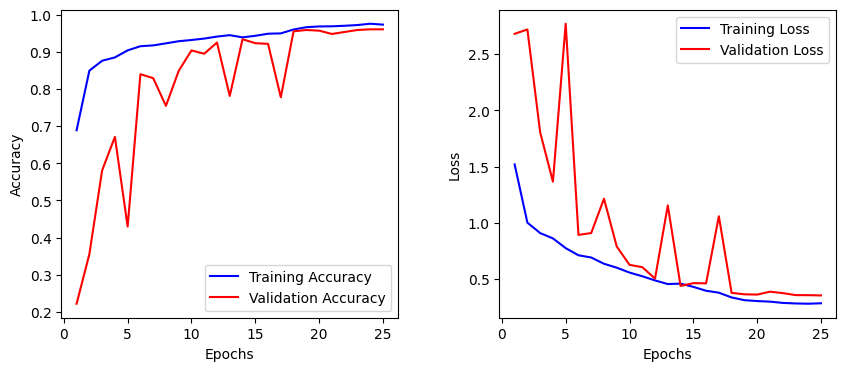

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

#Subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
plt.subplots_adjust(wspace=0.3)
axes[0].plot(epochs, acc, 'b', label='Training Accuracy')
axes[0].plot(epochs, val_acc, 'r', label='Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'b', label='Training Loss')
axes[1].plot(epochs, val_loss, 'r', label='Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

In [47]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           51

 Total params: 1,652,974 (6.31 MB)

 Trainable params: 550,692 (2.10 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 1,101,386 (4.20 MB)

In [48]:
y_test

pred = model.predict(X_test)
y_pred = (pred>0.5)

print("              Third CNN model classification report")
print(classification_report(y_test, y_pred))

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
              Third CNN model classification report
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       154
           1       0.91      0.96      0.94       113
           2       0.98      0.94      0.96       185
           3       0.97      0.99      0.98       111

   micro avg       0.96      0.96      0.96       563
   macro avg       0.96      0.96      0.96       563
weighted avg       0.96      0.96      0.96       563
 samples avg       0.96      0.96      0.96       563



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


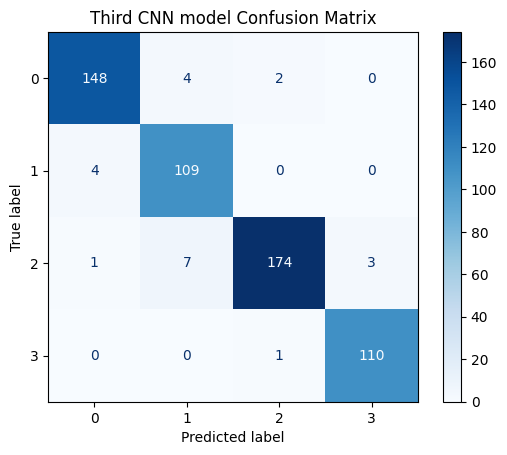

In [49]:
y_pred_probs = model.predict(X_test)
y_pred_probs = (y_pred_probs>0.5)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Third CNN model Confusion Matrix")
plt.show()

Hyper parameter tuning process


In [92]:
#hyperparameter tuning of third CNN model

In [93]:
!pip install keras_tuner

In [94]:
def build_model(hp):
    model = Sequential()


    model.add(Conv2D(hp.Int('units_1',min_value=32,max_value=512,step=32),(3,3),activation='relu', input_shape=(32,32,3),padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Conv2D(hp.Int('units_1',min_value=32,max_value=512,step=32),(3,3),activation='relu',padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(hp.Int('units_1',min_value=32,max_value=512,step=32),(3,3),activation='relu',input_shape=(32,32,3),padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Conv2D(hp.Int('units_1',min_value=32,max_value=512,step=32),(3,3),activation='relu',padding='same', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(4,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model


Hyperparameter tuning (max trials = 10, epoch = 10, batch size = 100)

In [98]:
tuner = RandomSearch(build_model,objective='val_accuracy',max_trials=10,executions_per_trial=1,directory='my_dir',project_name='hyperparam_train')

tuner.search(X_train,y_train,epochs=25,batch_size=100,
             validation_data=(X_val,y_val))

Reloading Tuner from my_dir/hyperparam_train/tuner0.json


In [99]:
best_hp = tuner.get_best_hyperparameters(num_trials = 1)[0]
print("Best Hyperparameters: \n",best_hp.values)
best_hp = tuner.get_best_hyperparameters(num_trials = 1)[0]
print("Best Hyperparameters: \n",best_hp.values)


CNN_History1 = CNN_Model1.fit(X_train,y_train,epochs = 25,batch_size = 100,validation_data = (X_val, y_val))


reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
CNN_Model1 = tuner.hypermodel.build(best_hp)
CNN_History1 = CNN_Model1.fit(X_train, y_train, epochs=25,
                              batch_size=100, validation_data=(X_val,y_val),
                              callbacks=[early_stopping, reduce_lr])
CNN_Model1.summary()

Best Hyperparameters: 
 {'units_1': 160}
Best Hyperparameters: 
 {'units_1': 160}
Epoch 1/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9601 - loss: 0.3924 - val_accuracy: 0.9059 - val_loss: 0.5855
Epoch 2/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9582 - loss: 0.4072 - val_accuracy: 0.8490 - val_loss: 0.9065
Epoch 3/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9595 - loss: 0.4123 - val_accuracy: 0.9396 - val_loss: 0.4908
Epoch 4/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9620 - loss: 0.3920 - val_accuracy: 0.9023 - val_loss: 0.6766
Epoch 5/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9556 - loss: 0.3987 - val_accuracy: 0.9325 - val_loss: 0.5381
Epoch 6/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9655 - loss: 0.3816 - val_accuracy: 0.8703 - val_loss: 0.8918
Epoch 7/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9612 - loss: 0.3958 - val_accuracy: 0.8970 - val_loss: 0.6033
Epoch 8/25
103/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 104ms/step - accuracy: 0.5831 - loss: 2.8645 - val_accuracy: 0.2327 - val_loss: 4.0864 - learning_rate: 0.0010
Epoch 2/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8250 - loss: 1.1887 - val_accuracy: 0.2220 - val_loss: 14.3869 - learning_rate: 0.0010
Epoch 3/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8468 - loss: 1.0705 - val_accuracy: 0.2025 - val_loss: 20.3826 - learning_rate: 0.0010
Epoch 4/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8613 - loss: 0.9706 - val_accuracy: 0.3091 - val_loss: 8.0150 - learning_rate: 0.0010
Epoch 5/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8849 - loss: 0.8530 - val_accuracy: 0.3606 - val_loss: 5.1195 - learning_rate: 0.0010
Epoch 6/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8910 - loss: 0.7946 - val_accuracy: 0.4618 - val_loss: 5.7589 - learning_rate: 0.0010
Epoch 7/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9122 - loss

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 160)    │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 32, 160)    │           640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 160)    │       230,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32, 32, 160)    │           640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 160)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 160)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 160)    │       230,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 16, 16, 160)    │           640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 160)    │       230,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 16, 16, 160)    │           640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 160)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 8, 8, 160)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 10240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     1,310,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,027,694 (22.99 MB)

 Trainable params: 2,008,804 (7.66 MB)

 Non-trainable params: 1,280 (5.00 KB)

 Optimizer params: 4,017,610 (15.33 MB)

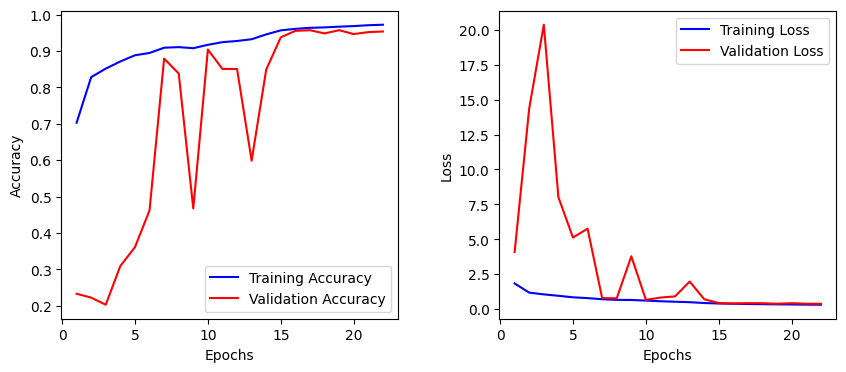

In [100]:
acc = CNN_History1.history['accuracy']
val_acc = CNN_History1.history['val_accuracy']
loss = CNN_History1.history['loss']
val_loss = CNN_History1.history['val_loss']

epochs = range(1, len(acc)+1)

#Subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
plt.subplots_adjust(wspace=0.3)
axes[0].plot(epochs, acc, 'b', label='Training Accuracy')
axes[0].plot(epochs, val_acc, 'r', label='Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'b', label='Training Loss')
axes[1].plot(epochs, val_loss, 'r', label='Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

In [101]:
y_test

pred = CNN_Model1.predict(X_test)
y_pred = (pred>0.5)

print("              HP second CNN model classification report")
print(classification_report(y_test, y_pred))

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
              HP second CNN model classification report
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       154
           1       0.91      0.96      0.94       113
           2       0.98      0.93      0.96       185
           3       0.97      0.98      0.98       111

   micro avg       0.96      0.96      0.96       563
   macro avg       0.95      0.96      0.96       563
weighted avg       0.96      0.96      0.96       563
 samples avg       0.96      0.96      0.96       563



18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


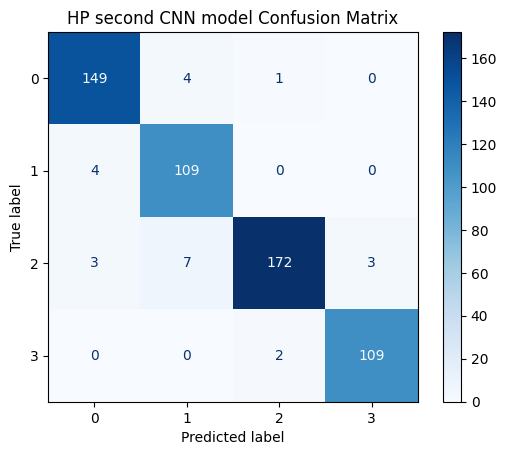

In [102]:
y_pred_probs = CNN_Model1.predict(X_test)
y_pred_probs = (y_pred_probs>0.5)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("HP second CNN model Confusion Matrix")
plt.show()